## part 1

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
data = np.loadtxt('zipcombo.dat')
data_1 = np.loadtxt('dtrain123.dat')


# extracting image and labels

y = data[:,0].astype(int)
x = data[:, 1:]

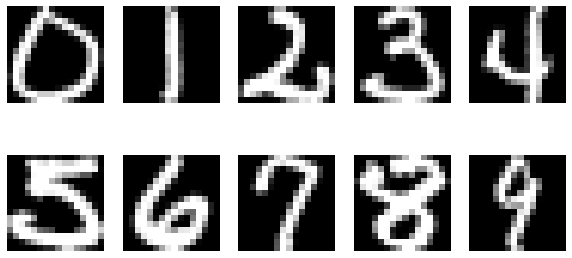

In [73]:
# generating sample images:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x[np.argwhere(y==i)[0],:].reshape(16,16), cmap = "gray")
    plt.axis('off')

#### training function

In [74]:
max_iter = 30
min_iter = 5

# defining the polynomial kernel with degree as input argument
def poly_kernel(xi,xj, degree):
    return np.dot(xi,xj.T)**degree


# defining the training function for one-versus-rest
# generalised kernel percpetron:

def multiclassOvR(X_data,y_data, degree, kernel_function):

    #generate kernel matrix:
    kernel_mtx = kernel_function(X_data,X_data, degree)
    #initialisation
    ini_weight = np.zeros((10, X_data.shape[0]))
    weight = ini_weight

    # record running mistakes to calculate training acuracy
    mistake_count = 0
    accuracy= []
    n,d = X_data.shape

    # training loop:
    for nIter in range(max_iter):

        # randomly shuffle the data before training to simulate an online
        # learning setting
        indices= list(range(n))
        np.random.shuffle(indices)

        # online algorithm receives the data
        for i in indices:
            # generating prediction
            y_pred = np.argmax(weight @ kernel_mtx[i,:])
            # assessing correctness and update the model correspondingly
            if y_data[i] != y_pred:
                mistake_count +=1
                weight[int(y_data[i]), i] +=1   # update the correct classifier by +1
                weight[int(y_pred), i] -=1      # vice versa
        
        accuracy.append((n-mistake_count)/n)    # training accuracy
        mistake_count = 0
        # print('epoch', str(nIter+1) ,': \n ', 'Current Accuracy is', accuracy[nIter] )
        
        #stopping criterion:
        if (nIter >= min_iter) and (accuracy[-1]-accuracy[-2]<0.01):
            break
        else:
            continue

    return weight, accuracy

#===================================================================================================
#===================================================================================================


# contructing a list containing the index of all classifier
binary_comb = list(itertools.combinations(range(10),2))

# defining a voting scheme to produce prediction
def voting(confidence):

    vote_count = np.zeros(10)                        # counting votes
    vote = ((np.sign(confidence)+2)//2).astype(int)  # calculate prediction for eaach classifier
    for i,j in enumerate(vote.tolist()):
        vote_count[binary_comb[i][int(j)]] +=1       # counting votes
    return np.argmax(vote_count)                     # making prediction


# defining the training function for one-versus-one
# generalised kernel percpetron:

def multiclassOvO(X_data,y_data, degree, kernel_function):

    #generate kernel matrix:
    kernel_mtx = kernel_function(X_data,X_data, degree)
    #initialisation
    ini_weight = np.zeros((45, X_data.shape[0]))
    mistake_count = 0
    accuracy= []
    n,d = X_data.shape

    weight = ini_weight
    for nIter in range(max_iter):
        indices= list(range(n))
        np.random.shuffle(indices) 
        

        for i in indices:
            confidence = weight @ kernel_mtx[i,:]
            y_pred= voting(confidence)          # making prediction

            if (y_pred != y_data[i]):
                mistake_count += 1

            for index, (p, q) in enumerate(binary_comb):
                                                                        # in which case:
                if y_data[i]==p and np.sign(confidence[index])!=-1:     # y should be in the negative class    
                    weight[index, i] -=1                                # lower alpha by 1
                elif y_data[i]==q and np.sign(confidence[index])!=1:    # y should be in the positive class
                    weight[index, i] +=1                                # increase alpha by 1


        
        accuracy.append((n-mistake_count)/n)
        mistake_count = 0
        # print('epoch', str(nIter+1) ,': \n ', 'Current Accuracy is', accuracy[nIter] )
        
        #stopping criterion
        if (nIter >= 2) and (accuracy[-1]-accuracy[-2]<0.1):
            break
        else:
            continue

    return weight, accuracy


#### data processing function

In [75]:
# defining function to split the dataset into training and testing

def train_test_split(X_data, y_data, percent =0.8):
    n,d = X_data.shape
    indices= list(range(n))
    np.random.shuffle(indices)
    split = int(percent*n)
    train_x, test_x = X_data[indices[:split]], X_data[indices[split:]]
    train_y, test_y = y_data[indices[:split]], y_data[indices[split:]]
    return train_x,train_y, test_x,test_y

#=======================================================================================================
    
# defining function to split the dataset into k-fold

def kfold_validation(X_data, y_data, k):
    n,d = X_data.shape
    indices = list(range(n))
    np.random.shuffle(indices)
    split_indices = np.array_split(indices, k)
    kfold_data =[]
    for i in range(k):
        valid_x, train_x = X_data[split_indices[i]], X_data[np.setdiff1d(indices, split_indices[i])]
        valid_y, train_y = y_data[split_indices[i]], y_data[np.setdiff1d(indices, split_indices[i])]
        kfold_data.append([train_x,train_y, valid_x,valid_y])
    return kfold_data

#### testing function

In [76]:
# defining a testing function to compute both test error and confusion matrix
def KP_test(X_train,X_test,y_test, weight,degree, kernel_function):

    # generating prediction using weight of trained model
    test_kernel_mtx = kernel_function(X_train, X_test,degree)
    y_pred = np.argmax(weight @ test_kernel_mtx,axis =0)

    # calculating error rate
    test_error = np.sum(y_pred != y_test)/len(y_test)

    # constructing confusion matrix
    confusion_mtx = np.zeros((10,10))
    for i,j in zip(y_test, y_pred):
        if i != j:                      # if the prediction is incorrect
            confusion_mtx[i,j] += 1     # record the mistake

            # compute entries of the matrix
            confusion_mtx = np.nan_to_num(confusion_mtx.T/np.sum(confusion_mtx, axis = 1)).T

    return test_error, confusion_mtx

# defining a similar function for one-vevrsus-one kernel perceptron
def KP_test_OvO(X_train,X_test,y_test, weight,degree, kernel_function):
    test_kernel_mtx = kernel_function(X_train, X_test,degree)
    y_pred = np.zeros(len(y_test))
    # generating prediction using the voting function
    for index in range(len(y_test)):
        y_pred[index] = voting(weight @ test_kernel_mtx[:,index])
    y_pred = y_pred.astype(int)

    test_error = np.sum(y_pred != y_test)/len(y_test)

    return test_error

#### function to compute data required by Q1

In [77]:
# function to output " basic result" question
def Q1_function(x_data,y_data, kernel_function, gen_method, test_f):

    Q1_data =[]
    for i in range(7):
        test_error_list =[]
        train_error_list =[]
#==================================================================================================       
        if kernel_function == poly_kernel:         # assigning different feasible parameter range
            degree = i+1                           # depending on which kernel function
        else: 
            degree = 3**(-i-1)
#==================================================================================================
        for run in range(20):
            # training on 80% of the dataset
            x_train,y_train,x_test,y_test = train_test_split(x_data,y_data)
            weight, accuracy = gen_method(x_train,y_train,degree, kernel_function)
#==================================================================================================            
            # test error are evaluated differently depending on which generalisatoin method
            if test_f == KP_test:
                test_error,_ = test_f(x_train,x_test,y_test,weight,degree, kernel_function)
            else:
                test_error = test_f(x_train,x_test,y_test,weight,degree, kernel_function)
#==================================================================================================
            test_error_list.append(test_error)          # recording the error rates
            train_error_list.append(1-accuracy[-1])

        # compute mean and std:
        Q1_data.append([np.mean(train_error_list), np.std(train_error_list), np.mean(test_error_list), np.std(test_error_list)])
    return (np.array(Q1_data)*100).round(3)


#### function to compute data required by Q2 and Q3

In [104]:
# function to output "cross validation" and "confusion matrix" question:

def Q2_Q3_function(x_data,y_data,kernel_function, gen_method,test_f):
    data_run=[]
    confusion_mistake =[]
    for run in range(20):
        # split the data into k-fold
        x_train,y_train,x_test,y_test = train_test_split(x_data,y_data)
        fold_data= kfold_validation(x_train,y_train,5)
        data_i = []

        for i in range(7):
            kfold_test_error = []
#==================================================================================================
            if kernel_function != poly_kernel:        # assigning different feasible parameter range
                degree = 3**(-i-1)                    # depending on which kernel function
            else: degree = i+1
#==================================================================================================
            

            for j in range(5):
                # k-fold training:
                fold_x,fold_y, valid_x,valid_y = fold_data[j]
                weight,_ = gen_method(fold_x,fold_y,degree,kernel_function)


#==================================================================================================
                # test error are evaluated differently depending on which generalisatoin method
                if test_f == KP_test:       #OvR generalisation
                    kfold_test_error.append(test_f(fold_x,valid_x,valid_y,weight,degree, kernel_function)[0])
                else:                       #OvO generalisation
                    kfold_test_error.append(test_f(fold_x,valid_x,valid_y,weight,degree, kernel_function))
#==================================================================================================
            
            
            data_i.append(np.mean(kfold_test_error))
        if kernel_function != poly_kernel:
            d_star = np.power(float(3),(-np.argmin(data_i)-1))           # obtaining optimal d_star and corresponding model
        else: d_star = np.argmin(data_i)+1
        
        optimal_weight,_ = gen_method(x_train, y_train, d_star, kernel_function)

    # test for OvO generalisation does not need to compute confusion matrix

        if test_f == KP_test:   #OvR generalisation
            rate, mtx = test_f(x_train, x_test, y_test,optimal_weight,d_star, kernel_function)
            data_run.append([d_star, rate])
            confusion_mistake.append(mtx)

        else:                   #OvO generalisation
            rate= test_f(x_train, x_test, y_test,optimal_weight,d_star, kernel_function)
            data_run.append([d_star, rate])

    if test_f == KP_test:
        return np.array(data_run), np.array(confusion_mistake)
    else:
        return np.array(data_run)



# Q1

In [79]:
Q1_train_test_error = Q1_function(x,y, poly_kernel, multiclassOvR, test_f = KP_test)
Q1_train_test_error

C:\Users\jonas\AppData\Local\Temp/ipykernel_38640/1114347381.py:18: RuntimeWarning: invalid value encountered in true_divide
  confusion_mtx = np.nan_to_num(confusion_mtx.T/np.sum(confusion_mtx, axis = 1)).T


array([[7.35 , 0.219, 9.086, 1.224],
       [1.234, 0.153, 4.263, 0.556],
       [0.517, 0.079, 3.653, 0.404],
       [0.305, 0.071, 3.32 , 0.313],
       [0.175, 0.088, 3.188, 0.385],
       [0.136, 0.058, 3.116, 0.423],
       [0.106, 0.062, 3.202, 0.349]])

# Q2 & Q3

In [80]:
Q2_data, Q3_data = Q2_Q3_function(x,y,poly_kernel,gen_method=multiclassOvR, test_f=KP_test)

C:\Users\jonas\AppData\Local\Temp/ipykernel_38640/1114347381.py:18: RuntimeWarning: invalid value encountered in true_divide
  confusion_mtx = np.nan_to_num(confusion_mtx.T/np.sum(confusion_mtx, axis = 1)).T


In [123]:
cross_table = np.array(Q2_data)
cross_table[:,-1] *= 100
print(cross_table)

[[4.         3.5483871 ]
 [5.         3.70967742]
 [4.         3.60215054]
 [4.         2.90322581]
 [6.         2.58064516]
 [6.         2.41935484]
 [7.         3.17204301]
 [6.         3.38709677]
 [6.         2.74193548]
 [5.         3.06451613]
 [5.         4.46236559]
 [7.         3.70967742]
 [7.         2.95698925]
 [5.         2.79569892]
 [5.         2.74193548]
 [6.         3.49462366]
 [7.         3.22580645]
 [6.         2.79569892]
 [5.         3.27956989]
 [4.         3.97849462]]


In [124]:
print(np.mean(Q3_data, axis =0).round(3))
print(np.std(Q3_data, axis =0).round(3))

[[0.    0.063 0.088 0.108 0.082 0.213 0.19  0.014 0.127 0.066]
 [0.    0.    0.075 0.    0.309 0.025 0.181 0.119 0.112 0.028]
 [0.121 0.022 0.    0.234 0.203 0.015 0.039 0.182 0.102 0.082]
 [0.04  0.002 0.146 0.    0.    0.461 0.    0.138 0.143 0.071]
 [0.013 0.134 0.179 0.025 0.    0.076 0.023 0.115 0.027 0.308]
 [0.189 0.    0.108 0.252 0.077 0.    0.111 0.102 0.081 0.08 ]
 [0.325 0.079 0.135 0.    0.251 0.141 0.    0.    0.07  0.   ]
 [0.    0.067 0.135 0.111 0.238 0.069 0.    0.    0.053 0.326]
 [0.208 0.035 0.07  0.222 0.158 0.113 0.038 0.056 0.    0.1  ]
 [0.006 0.093 0.006 0.06  0.446 0.079 0.    0.266 0.044 0.   ]]
[[0.    0.15  0.13  0.192 0.172 0.206 0.254 0.055 0.2   0.155]
 [0.    0.    0.179 0.    0.373 0.109 0.283 0.2   0.253 0.109]
 [0.212 0.059 0.    0.272 0.209 0.037 0.095 0.226 0.203 0.178]
 [0.137 0.007 0.237 0.    0.002 0.32  0.    0.193 0.195 0.174]
 [0.054 0.2   0.301 0.109 0.    0.16  0.045 0.255 0.109 0.298]
 [0.213 0.    0.212 0.309 0.128 0.    0.155 0.18  0.13

## Q4

In [81]:
Q4_data =np.zeros_like(y)

# 40 runs to find out the 5 hardest images to classify
for run in range(40):
    # training
    x_train,y_train,x_test,y_test = train_test_split(x,y)
    weight, _ = multiclassOvR(x_train,y_train,6,poly_kernel)
    # predicting
    test4_kernel_mtx = poly_kernel(x_train, x,6)
    y_pred = np.argmax(weight @ test4_kernel_mtx,axis =0)
    
    #counting incorrect prediction
    Q4_data[np.argwhere(y_pred != y)]+=1

#output the 5 most often misclassified
print(np.argsort(Q4_data)[-5:])

[7524 7807 3227 8261 5296]


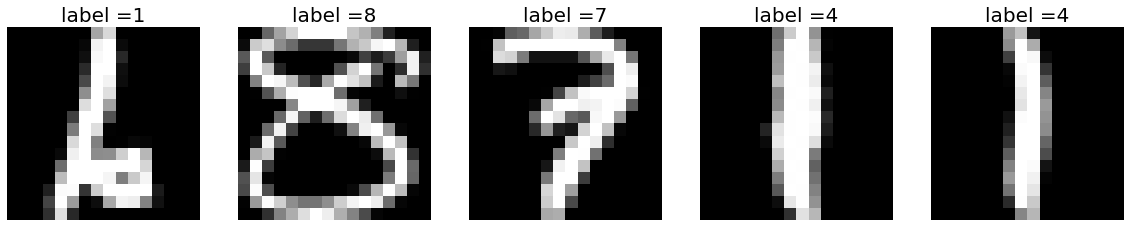

In [82]:
# visualising the 5 images

worst5 = np.argsort(Q4_data)[-5:]

plt.figure(figsize = (20,8))
for i,j in enumerate(worst5):
    plt.subplot(2,5,i+1)
    plt.imshow(x[j,:].reshape(16,16), cmap = "gray")
    plt.title('label =%.0f' % int(y[j]), fontsize=20)
    plt.axis('off')


## Q5

In [83]:
def kernel_gaussian(xi, xj, c):
    xi_norm = np.sum(xi**2, axis =-1)
    xj_norm = np.sum(xj**2, axis =-1)
    return np.exp(-c*(xi_norm[:, None] + xj_norm[None,:]-2*(xi @ xj.T)))

In [109]:
min_iter = 7
GaussQ1_error = Q1_function(x,y,kernel_gaussian,multiclassOvR,KP_test)
print(GaussQ1_error)

array([[0.000e+00, 0.000e+00, 6.132e+00, 6.490e-01],
       [7.000e-03, 1.200e-02, 5.022e+00, 4.500e-01],
       [2.900e-02, 2.200e-02, 3.392e+00, 3.580e-01],
       [1.160e-01, 3.800e-02, 3.097e+00, 4.490e-01],
       [8.420e-01, 1.610e-01, 4.097e+00, 6.940e-01],
       [4.393e+00, 2.670e-01, 6.656e+00, 1.676e+00],
       [8.778e+00, 2.720e-01, 1.050e+01, 4.141e+00]])

In [105]:
GaussQ2_table = Q2_Q3_function(x,y,kernel_gaussian,multiclassOvR,KP_test)

C:\Users\jonas\AppData\Local\Temp/ipykernel_38640/1114347381.py:18: RuntimeWarning: invalid value encountered in true_divide
  confusion_mtx = np.nan_to_num(confusion_mtx.T/np.sum(confusion_mtx, axis = 1)).T


In [119]:
cross_table2 = np.array(GaussQ2_table[0])
cross_table2[:,-1] *= 100
print(cross_table2.round(3))

[[0.012 3.387]
 [0.037 3.065]
 [0.012 3.763]
 [0.012 2.796]
 [0.012 2.688]
 [0.012 3.495]
 [0.012 3.495]
 [0.012 3.28 ]
 [0.037 2.849]
 [0.012 3.763]
 [0.012 3.065]
 [0.012 3.656]
 [0.012 2.957]
 [0.012 3.763]
 [0.012 2.634]
 [0.012 2.903]
 [0.037 4.301]
 [0.012 2.903]
 [0.012 2.796]
 [0.012 3.011]]


# Q6

In [120]:
min_iter = 3
Q6_I_data = Q1_function(x,y, poly_kernel, multiclassOvO, test_f=KP_test_OvO)
print(Q6_I_data)

[[6.213 0.259 7.465 1.115]
 [2.312 0.168 4.414 0.523]
 [1.383 0.182 3.954 0.473]
 [1.07  0.117 3.667 0.482]
 [0.919 0.129 3.637 0.564]
 [0.818 0.119 3.548 0.576]
 [0.717 0.13  3.634 0.48 ]]


In [122]:
Q6_II_data = Q2_Q3_function(x,y,poly_kernel,gen_method=multiclassOvO, test_f=KP_test_OvO)
print(Q6_II_data.round(4))

[[5.     0.0366]
 [3.     0.0403]
 [4.     0.1027]
 [5.     0.0339]
 [6.     0.0328]
 [4.     0.0376]
 [5.     0.0371]
 [7.     0.036 ]
 [5.     0.0328]
 [4.     0.0349]
 [4.     0.0398]
 [7.     0.0382]
 [5.     0.0204]
 [4.     0.0317]
 [5.     0.0301]
 [7.     0.0285]
 [7.     0.0296]
 [3.     0.036 ]
 [4.     0.0328]
 [4.     0.0403]]
